C:\Users\0860\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/bias:0', 'vit/pooler/dense/kernel:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Found 4996 images belonging to 9 classes.
Found 1404 images belonging to 9 classes.
Epoch 1/8


313/313 [==============================] - 4186s 13s/step - loss: 1.0287 - accuracy: 0.7242 - val_loss: 0.4468 - val_accuracy: 0.8981
Epoch 2/8
313/313 [==============================] - 4046s 13s/step - loss: 0.4164 - accuracy: 0.8819 - val_loss: 0.3718 - val_accuracy: 0.8903
Epoch 3/8
313/313 [==============================] - 46006s 147s/step - loss: 0.2753 - accuracy: 0.9155 - val_loss: 0.2463 - val_accuracy: 0.9238
Epoch 4/8
313/313 [==============================] - 5127s 16s/step - loss: 0.1826 - accuracy: 0.9458 - val_loss: 0.2923 - val_accuracy: 0.9024
Epoch 5/8
313/313 [==============================] - 5255s 17s/step - loss: 0.1439 - accuracy: 0.9590 - val_loss: 0.3315 - val_accuracy: 0.8967
Epoch 6/8
313/313 [==============================] - 4431s 14s/step - loss: 0.0928 - accuracy: 0.9746 - val_loss: 0.3644 - val_accuracy: 0.8853
Epoch 7/8
313/313 [=============================

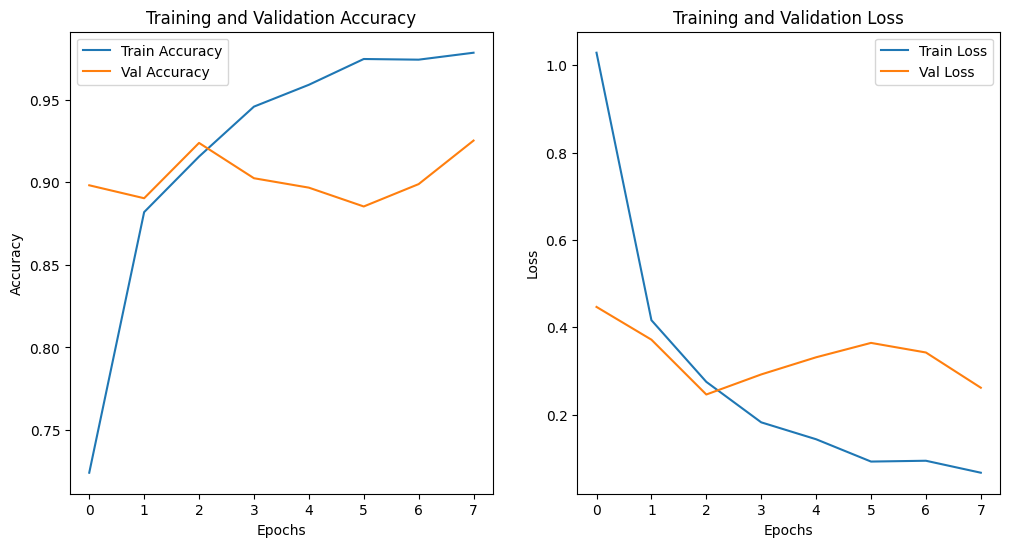

In [1]:
import os
import tensorflow as tf
from transformers import ViTFeatureExtractor, TFViTForImageClassification
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Disable MKL optimizations if necessary
os.environ["MKL_DISABLE_FAST_MM"] = "1"

# Constants
input_shape = (128, 128)  # Reduced input size to lower memory usage
batch_size = 16  # Smaller batch size for simplicity and to reduce memory load
num_classes = 9  

# Load ViT model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = TFViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k", num_labels=num_classes
)

# Preprocess input to ViT
def preprocess_vit_input(images):
    if isinstance(images, np.ndarray):
        images = list(images)
    pixel_values = feature_extractor(images=images, return_tensors="tf").pixel_values
    return pixel_values

# Function to create a generator that preprocesses images for ViT
def vit_data_generator(generator):
    while True:
        batch, labels = next(generator)
        vit_batch = preprocess_vit_input(batch)
        yield vit_batch, labels

# Load data using ImageDataGenerator for directory loading
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    'train_data',
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'test_data',
    target_size=input_shape,
    batch_size=batch_size,
    class_mode='categorical'
)

# Compile ViT model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

vit_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model
history = vit_model.fit(
    vit_data_generator(train_generator),
    validation_data=vit_data_generator(test_generator),
    epochs=8,  
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator)
)

# Save the model weights and architecture to an h5 file
vit_model.save_weights('vit_model_weights.h5')  # Save weights in .h5 format

# Save the model architecture separately to a JSON file
model_json = vit_model.to_json()  # Serialize the model architecture
with open("vit_model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Plot Training and Validation Accuracy/Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the history
plot_training_history(history)

In [8]:
from PIL import Image
import numpy as np
import tensorflow as tf
from transformers import ViTFeatureExtractor, TFViTForImageClassification

# Load the pre-trained ViT model and feature extractor
vit_model = TFViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=9)
vit_model.load_weights('vit_model_weights.h5')

# Load the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Function to preprocess input image for ViT
def preprocess_image_for_vit(img_path):
    # Load the image using PIL
    img = Image.open(img_path).convert("RGB")  # Ensure the image is in RGB mode
    # Resize the image to the input shape expected by the model
    img = img.resize((224, 224))  # Resize to the input size expected by the ViT model
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Preprocess the image using the feature extractor
    pixel_values = feature_extractor(images=img_array, return_tensors="tf").pixel_values
    return pixel_values

# Prediction function
def predict_image(img_path):
    # Preprocess the image
    preprocessed_image = preprocess_image_for_vit(img_path)
    
    # Make a prediction
    prediction_logits = vit_model(preprocessed_image).logits
    predicted_class = np.argmax(prediction_logits, axis=-1)
    
    # Print predicted class label
    class_labels = ['A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'O+', 'O-', 'unknown']  # Replace with your actual class names
    print(f"Predicted Class: {class_labels[predicted_class[0]]}")

# Example of using the prediction logic
img_path = 'test_data/A+/cluster_0_539.BMP'  
predict_image(img_path)

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/bias:0', 'vit/pooler/dense/kernel:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted Class: A+
